# KNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
np.random.seed(1)

In [4]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [5]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries

In [6]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list, extract_fingerprint_df

In [7]:
from collections import defaultdict

## Read Train/Test Assignment

In [8]:
supervision_df = pd.read_csv("../../data/output/20230902_semi_supervision_setup.csv", index_col=0)

In [9]:
supervision_df["site_id"] = supervision_df["site_id"].astype("category")
supervision_df["floor_id"] = supervision_df["floor_id"].astype("category")
supervision_df["dataset"] = supervision_df["dataset"].astype("category")

In [10]:
no_supervision_floor_df = supervision_df[supervision_df["supervision_pct"] == 0.0]

In [11]:
train_test_assignment = pd.read_csv("../../data/output/20230902_train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

In [12]:
train_test_assignment_df = pd.merge(no_supervision_floor_df[["site_id", "floor_id"]], train_test_assignment, on=["site_id", "floor_id"])

In [13]:
unique_floors = train_test_assignment_df[["site_id", "floor_id"]].drop_duplicates().values

In [14]:
print("The number of floors:", unique_floors.shape[0])

The number of floors: 219


## Extract Fingerprint Data for a Specific Floor

In [181]:
site_id, floor_id = unique_floors[2]
base_data_dir = "../../data/wifi_fingerprint_manual/train/"

In [182]:
track_assignment = train_test_assignment[(train_test_assignment["site_id"] == site_id) & (train_test_assignment["floor_id"] == floor_id)]

In [183]:
train_tracks = track_assignment[track_assignment["dataset"] == "train"]
test_tracks = track_assignment[track_assignment["dataset"] == "test"]

In [184]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str) -> list[str]:
  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}_wifi_fingerprint.csv"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [185]:
train_files = get_track_filepaths(train_tracks, base_data_dir)
test_files = get_track_filepaths(test_tracks, base_data_dir)

In [186]:
print(f"The number of train files: {len(train_files)}")
print(f"The number of test files: {len(test_files)}")

The number of train files: 92
The number of test files: 18


* Extract fingerprint dataframe

In [187]:
train_wifi_location_df_list = read_wifi_location_df_list(train_files)
test_wifi_location_df_list = read_wifi_location_df_list(test_files)

In [188]:
train_wifi_location_df = pd.concat(train_wifi_location_df_list)
test_wifi_location_df = pd.concat(test_wifi_location_df_list)

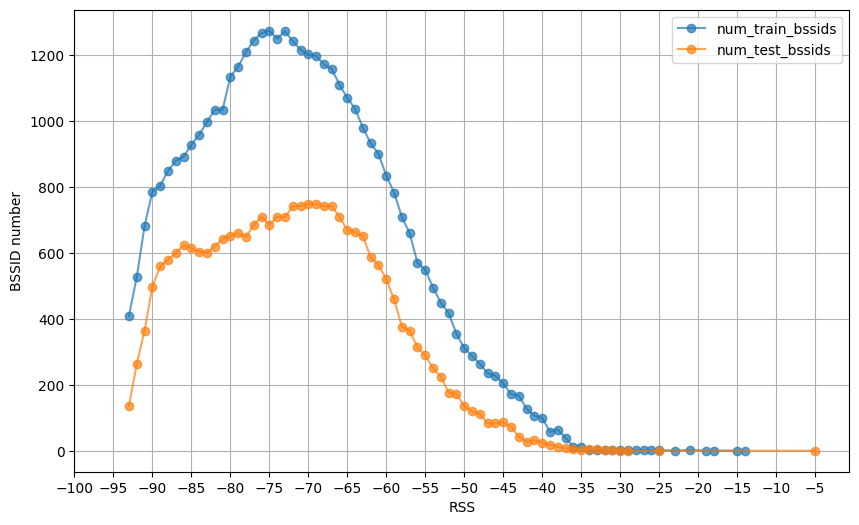

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(train_wifi_location_df.groupby("rssi")
 .agg({"bssid": pd.Series.nunique})
 .rename(columns={"bssid": "num_train_bssids"})
 .plot(marker="o", alpha=0.7, label="train", ax=ax))

(test_wifi_location_df.groupby("rssi")
 .agg({"bssid": pd.Series.nunique})
 .rename(columns={"bssid": "num_test_bssids"})
 .plot(marker="o", alpha=0.7, label="test", ax=ax))

ax.set_xlabel("RSS")
ax.set_ylabel("BSSID number")
ax.set_xticks(range(-100, 0, 5))
ax.grid()

plt.show()

* Create wifi fingerprint dataframes

In [193]:
train_fingerprint_df, train_bssid = extract_fingerprint_df(train_wifi_location_df_list, not_seen_rssi=-100)
test_fingerprint_df, test_bssid = extract_fingerprint_df(test_wifi_location_df_list, not_seen_rssi=-100)

* Extracting Floormap Data

In [194]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

In [195]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

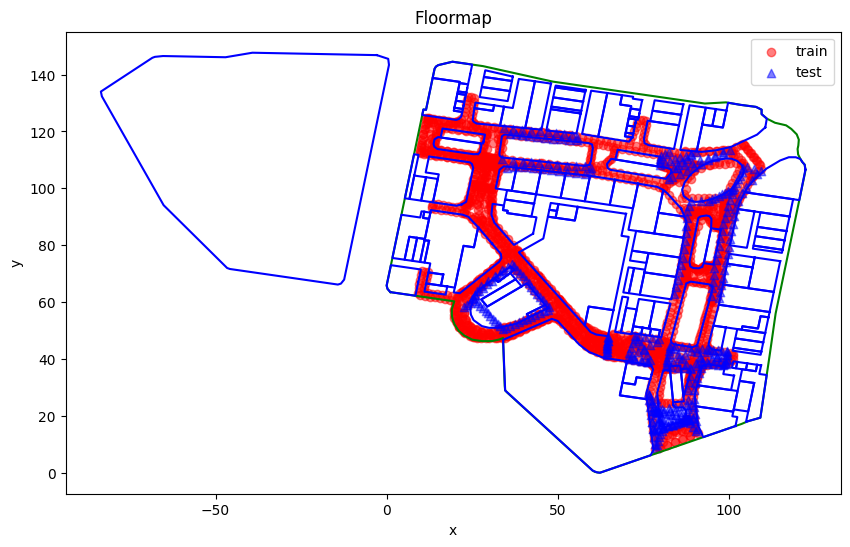

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

train_fingerprint_location = transform_func(train_fingerprint_df[["x", "y"]].values)
test_fingerprint_location = transform_func(test_fingerprint_df[["x", "y"]].values)
ax.scatter(train_fingerprint_location[:, 0],
           train_fingerprint_location[:, 1],
           marker="o",
           color="red",
           label="train",
           alpha=0.5)
ax.scatter(test_fingerprint_location[:, 0],
           test_fingerprint_location[:, 1],
           marker="^",
           color="blue",
           label="test",
           alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## KNN Regression

In [197]:
X_train = np.vstack(train_fingerprint_df["v"].values.tolist())
y_train = train_fingerprint_df[["x", "y"]].values

X_test= np.vstack(test_fingerprint_df["v"].values.tolist())
y_test = test_fingerprint_df[["x", "y"]].values

In [198]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [199]:
print(f"The number of train samples: {X_train.shape[0]}")
print(f"The number of test samples: {X_test.shape[0]}")

The number of train samples: 1853
The number of test samples: 403


* The first step is to translate the `X_test` in the test space into the associated vector in the train space.

In [200]:
def translate(X: np.ndarray, X_bssid: np.ndarray, target_bssid: np.ndarray, not_seen_ap_rss: float = -100):
  X_target = np.ones((X.shape[0], target_bssid.shape[0])) * not_seen_ap_rss
  for i, t_bssid in enumerate(target_bssid):
    indices = np.where(X_bssid == t_bssid)[0]

    if len(indices) == 1:
      X_target[:, i] = X[:, indices[0]]
  
  return X_target

In [201]:
bssid_all_set = {*set(train_bssid), *set(test_bssid)}
bssid_all_vector = np.array(list(bssid_all_set))

In [202]:
X_train_translated = translate(X_train, train_bssid, bssid_all_vector, -100)
X_test_translated  = translate(X_test, test_bssid, bssid_all_vector, -100)
assert X_train_translated.shape[1] == X_test_translated.shape[1]
assert X_train.shape[0] == X_train_translated.shape[0]
assert X_test.shape[0] == X_test_translated.shape[0]

### `kNN`

In [203]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.metrics import euclidean_distances

* Weighted Maximum Similarity Function
  * The idea behind WMS function is that WMS will get higher value if the input point and reference have more common APs and the RSS difference for nearby APs are smaller.

In [204]:
def weighted_maximum_similarity(v1: np.ndarray, v2: np.ndarray) -> np.float64:
  w = np.abs((v1 + v2) / 2)
  m = np.clip(np.abs(v1 - v2), a_min=1, a_max=None)
  return np.average(1.0 / m, weights=1.0 / w)


In [205]:
def weighted_maximum_distance(v1: np.ndarray, v2: np.ndarray) -> np.float64:
  return 1.0 - weighted_maximum_similarity(v1, v2)

In [206]:
weighted_maximum_similarity(X_train_translated[0], X_train_translated[1])

0.9218231759706117

* Finding the optimal k for `kNN` with weighted maximum metric

In [59]:
def compute_similarity_vector(X_query: np.ndarray, X_train: np.ndarray) -> np.ndarray:
  w = np.abs((X_query + X_train) / 2)
  m = np.clip(np.abs(X_query - X_train), a_min=1, a_max=None)
  return np.average(1.0 / m, weights=1.0 / w, axis=1)

In [60]:
def compute_similarity_matrix(X_test: np.ndarray, X_train: np.ndarray) -> np.ndarray:
  sim_matrix = np.zeros((len(X_test), len(X_train)), dtype=np.float64)

  for i, X_query in enumerate(X_test):
    sim_matrix[i, :] = compute_similarity_vector(X_query, X_train)

  return sim_matrix

In [61]:
def knn_regression(X_test: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, k: int) -> np.ndarray:
  assert k > 0, "k must be positive, found {}".format(k)

  y_test = np.zeros((len(X_test), 2), dtype=np.float64)

  for i, X_query in enumerate(X_test):
    sim_vector = compute_similarity_vector(X_query, X_train)
    top_k_indices = np.argsort(sim_vector)[::-1][:k]
    y_test[i, :] = np.average(y_train[top_k_indices], axis=0)

  return y_test

In [62]:
def knn_predict(sim_matrix: np.ndarray, y_train: np.ndarray, k: int):
  assert k > 0, "k must be positive, found {}".format(k)

  y_pred = np.zeros((len(sim_matrix), y_train.shape[1]))

  for i, sim_vector in enumerate(sim_matrix):
    y_pred[i, :] = y_train[np.argsort(sim_vector)[::-1][:k]].mean(axis=0)

  return y_pred

In [ ]:
sim_matrix = compute_similarity_matrix(X_test_translated, X_train_translated)

In [738]:
k_values = list(range(1, 10))
error_list = []

for n_neighbors in tqdm(k_values):
  y_pred = knn_predict(sim_matrix, y_train, k=n_neighbors)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  error_list.append(errors)

100%|██████████| 9/9 [00:00<00:00, 18.88it/s]


In [141]:
X_train_translated

array([[  -67.,  -100., -1000., ..., -1000., -1000., -1000.],
       [  -65.,  -100., -1000., ..., -1000., -1000., -1000.],
       [  -60.,  -100., -1000., ..., -1000., -1000., -1000.],
       ...,
       [-1000.,  -100.,   -71., ..., -1000., -1000., -1000.],
       [-1000.,  -100.,   -70., ..., -1000., -1000., -1000.],
       [-1000.,  -100.,   -76., ..., -1000., -1000., -1000.]])

In [148]:
def transform_rss(X, min_rss=-100):
  X_t = np.zeros_like(X)
  loc = np.where(X >= min_rss)
  X_t[loc] = X[loc] - min_rss
  return X_t


In [215]:
X_train_90 = transform_rss(X_train_translated, min_rss=-90)
X_test_90 = transform_rss(X_test_translated, min_rss=-90)

In [216]:
param_min_rss_thresholds = [-100, -95, -90, -85, -80]
dist_metrics = ["l1", "l2", "cosine"]

results = []

for metric in dist_metrics:
  for n_neighbors in [1, 2, 3, 4, 5, 6, 7, 8, 16, 32]:
    print(f"[INFO]: Running experiment for metric={metric}, n_neighbors={n_neighbors}")

    # Fitting models
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", algorithm="auto", metric=metric)
    _ = knn.fit(X_train_90, y_train)

    # Making predictions
    y_pred = knn.predict(X_test_90)
    errors = np.linalg.norm(y_test - y_pred, axis=1)

    # Summarize results
    result = {
      "metric": metric,
      "n_neighbors": n_neighbors,
      "count": errors.shape[0],
      "mean": errors.mean(),
      "std": errors.std(),
    }

    for p in [5, 10, 25, 50, 75, 90, 95]:
      result[f"p{p}"] = np.percentile(errors, p)
    
    results.append(result)

[INFO]: Running experiment for metric=l1, n_neighbors=1


[INFO]: Running experiment for metric=l1, n_neighbors=2
[INFO]: Running experiment for metric=l1, n_neighbors=3
[INFO]: Running experiment for metric=l1, n_neighbors=4
[INFO]: Running experiment for metric=l1, n_neighbors=5
[INFO]: Running experiment for metric=l1, n_neighbors=6
[INFO]: Running experiment for metric=l1, n_neighbors=7
[INFO]: Running experiment for metric=l1, n_neighbors=8
[INFO]: Running experiment for metric=l1, n_neighbors=16
[INFO]: Running experiment for metric=l1, n_neighbors=32
[INFO]: Running experiment for metric=l2, n_neighbors=1
[INFO]: Running experiment for metric=l2, n_neighbors=2
[INFO]: Running experiment for metric=l2, n_neighbors=3
[INFO]: Running experiment for metric=l2, n_neighbors=4
[INFO]: Running experiment for metric=l2, n_neighbors=5
[INFO]: Running experiment for metric=l2, n_neighbors=6
[INFO]: Running experiment for metric=l2, n_neighbors=7
[INFO]: Running experiment for metric=l2, n_neighbors=8
[INFO]: Running experiment for metric=l2, n_ne

In [217]:
result_df = pd.DataFrame(results)

In [218]:
result_df["mean"].min()

5.20745885265512

In [220]:
result_df[result_df["mean"] == result_df["mean"].min()]

,metric,n_neighbors,count,mean,std,p5,p10,p25,p50,p75,p90,p95
25,cosine,6,403,5.207459,3.31392,1.23723,1.569222,2.853759,4.589921,6.7239,9.866144,11.705451


In [214]:
result_df[result_df["metric"] == "cosine"]

,metric,n_neighbors,count,mean,std,p5,p10,p25,p50,p75,p90,p95
20,cosine,1,403,5.395553,3.761668,1.064893,1.595168,2.641686,4.547007,7.044922,10.492838,12.866356
21,cosine,2,403,4.931186,3.232671,1.099705,1.663083,2.629361,4.098706,6.509184,9.586252,11.166008
22,cosine,3,403,4.735310,3.147631,0.945384,1.529691,2.518975,4.016326,6.083237,9.080375,11.968867
23,cosine,4,403,4.819778,3.029852,1.144408,1.606331,2.684346,4.085974,6.450994,8.778580,11.291069
24,cosine,5,403,4.777282,3.001707,1.260377,1.675142,2.524192,4.076031,6.183380,9.023100,11.105257
25,cosine,6,403,4.787174,2.930231,1.291495,1.657247,2.707125,4.151834,6.085780,8.796754,10.909447
26,cosine,7,403,4.799781,2.902515,1.299749,1.733678,2.601234,4.304952,6.078959,8.651834,11.016496
27,cosine,8,403,4.892401,2.871890,1.260660,1.824236,2.864680,4.313241,6.194920,8.471094,10.723441
28,cosine,16,403,5.273913,2.933734,1.324397,2.034421,3.141552,4.710978,6.973733,9.218924,10.910359
29,cosine,32,403,6.166845,3.290866,1.796703,2.389578,3.840667,5.596250,7.810514,10.674719,13.124287


In [86]:
errors.mean(), np.percentile(errors, [95])

(9.906262718935286, array([26.87698592]))

In [102]:
knn = KNeighborsRegressor(n_neighbors=50, weights="uniform", algorithm="auto", metric="l1").fit(X_train_translated, y_train)


In [103]:
y_pred = knn.predict(X_test_translated)

In [104]:
errors = np.linalg.norm(y_test - y_pred, axis=1)

In [105]:
errors.mean(), np.percentile(errors, [95])

(11.039652315539184, array([24.9320004]))

In [808]:
np.where(error_list[0] > 16)[0]

array([ 33,  37,  38,  40,  52,  54,  60,  62,  75,  98, 102, 105, 107,
       109, 110, 112, 116, 118, 121, 123, 126, 134, 137, 138, 144, 147,
       148, 174, 175, 176, 178, 180, 293, 318, 379])

In [814]:
indices = np.argsort(sim_matrix[33])[::-1][:4]

In [816]:
sim_matrix[33][indices]

array([0.91872809, 0.91371618, 0.91329765, 0.91231209])

In [818]:
indices

array([1834,  566,  559,  564])

In [825]:
np.argsort(l2_dist[33])[:4]

array([1834,  566,  560,  564])

In [821]:
X_train_translated[np.argsort(l2_dist[33])[::-1][:4]]

array([[-100., -100., -100., ...,  -58., -100., -100.],
       [-100., -100., -100., ...,  -56., -100., -100.],
       [-100., -100., -100., ...,  -57., -100., -100.],
       [-100., -100., -100., ...,  -46., -100., -100.]])

In [827]:
pairwise_distances([X_test_translated[33]], X_train_translated[np.argsort(l2_dist[33])[:4]], metric="l1")

array([[1879., 2193., 2271., 2434.]])

In [870]:
cosine_dist = pairwise_distances(X_test_translated, X_train_translated, metric="cosine")

In [873]:
l1_dist = pairwise_distances(X_test_translated, X_train_translated, metric="l1")

In [867]:
y_train[np.argsort(sim_matrix[8])[::-1][:4]].mean(axis=0)

array([34.74462986, 59.23676109])

In [874]:
y_train[np.argsort(l1_dist[8])[:4]].mean(axis=0)

array([60.29537582, 46.09709167])

In [872]:
y_train[np.argsort(cosine_dist[8])[:4]].mean(axis=0)

array([60.36657619, 45.96897888])

In [875]:
y_test[33]

array([86.04473114, 21.47328758])

In [855]:
y_test[33]

array([86.04473114, 21.47328758])

In [837]:
np.linalg.norm(y_test[33] - y_train[indices].mean(axis=0))

8.398620257440882

In [838]:
error_list[0][33]

17.568652423476927

In [858]:
y_pred = knn_predict(sim_matrix, y_train, k=4)

In [859]:
errors = np.linalg.norm(y_pred - y_test, axis=1)

In [861]:
np.where(errors > 16)

(array([  8,  13,  23,  24,  25,  26,  28,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  51,  52,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  87, 105, 109, 111, 112,
        113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        129, 131, 132, 133, 136, 137, 138, 160, 161, 162, 164, 165, 166,
        167, 174, 175, 176, 177, 178, 179, 180, 187, 188, 189, 190, 198,
        200, 201, 202, 220, 244, 256, 270, 275, 276, 277, 294, 342, 345,
        346, 351, 356, 361, 362, 363, 364, 367, 369, 384, 385, 386, 395]),)

In [862]:
errors[8]

33.173217179959934

In [852]:
error_list[3][33]

8.066808974214918

In [715]:
l2_dist = euclidean_distances(X_test_translated, X_train_translated)

In [716]:
np.argsort(l2_dist[0])[:4]

array([1772, 1771, 1612, 1776])

In [717]:
indices = np.argsort(sim_matrix[0])[::-1][:4]

In [718]:
indices

array([1772, 1771, 1776, 1655])

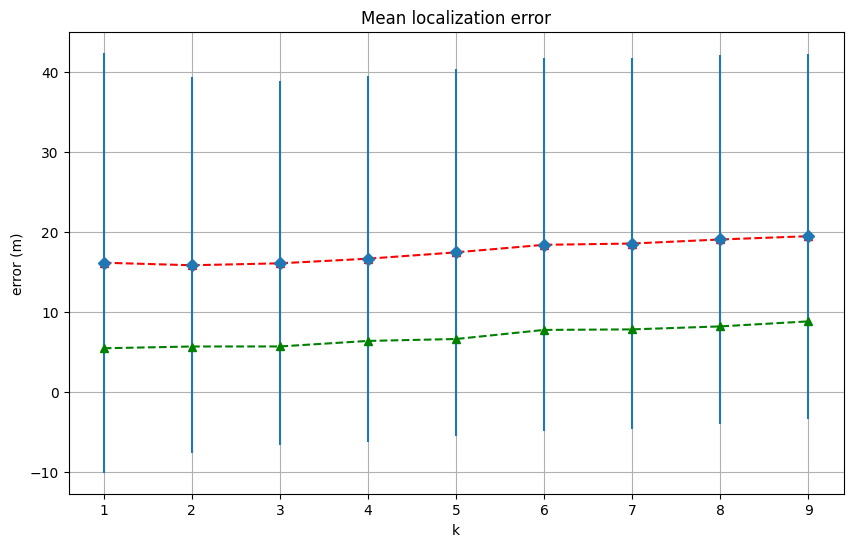

In [724]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()

plt.show()

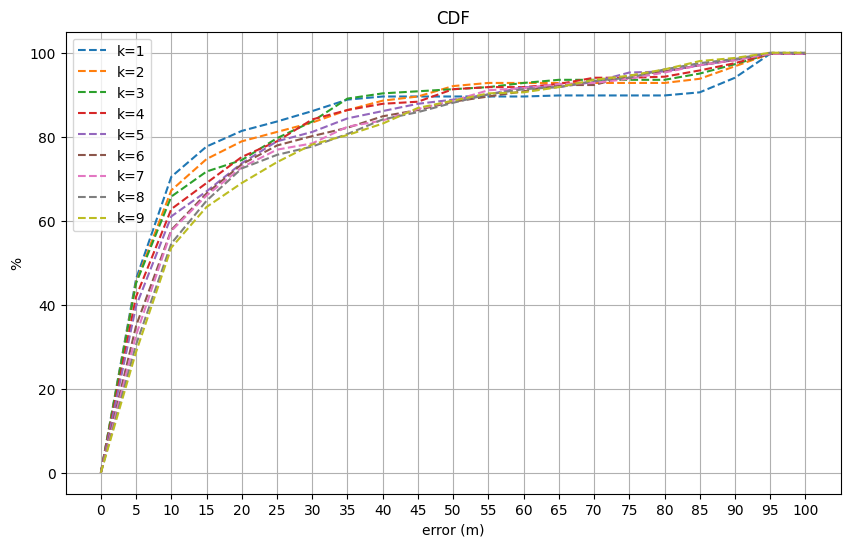

In [725]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = [i / 20 for i in range(51)]

for k, errors in zip(k_values, error_list):
  pdf, bins = np.histogram(errors, bins=20, range=(0, 100))
  pdf = pdf / errors.shape[0]
  error_cdf = np.cumsum(pdf)
  error_cdf = np.array([0, *error_cdf.tolist()])
  ax.plot(bins, error_cdf * 100, ls="--", label="k={}".format(k))

ax.set_xlabel("error (m)")
ax.set_ylabel("%")
ax.set_xticks(bins)
ax.set_title("CDF")

ax.grid()
ax.legend()

plt.show()

In [726]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=16.65m, std_error=22.87m


In [727]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=16.14m, std_error=26.23m


In [ ]:
k_values = list(range(1, 10))
error_list = []

sim_matrix = compute_similarity_matrix(X_target, X_train)

for n_neighbors in tqdm(k_values):
  y_pred = knn_predict(sim_matrix, y_train, k=n_neighbors)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  error_list.append(errors)

100%|██████████| 9/9 [00:00<00:00, 86.94it/s]


In [665]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=46.24m, std_error=25.05m


In [666]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=45.69m, std_error=24.94m


### `PCA` + `kNN`

In [644]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

In [728]:
# scaler = StandardScaler(with_mean=False).fit(X_train)
scaler = MaxAbsScaler().fit(X_train_translated)

In [729]:
X_train_scaled = scaler.transform(X_train_translated)
X_test_scaled = scaler.transform(X_test_translated)

In [730]:
pca = PCA()
_ = pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_csum = np.cumsum(pca.explained_variance_ratio_)

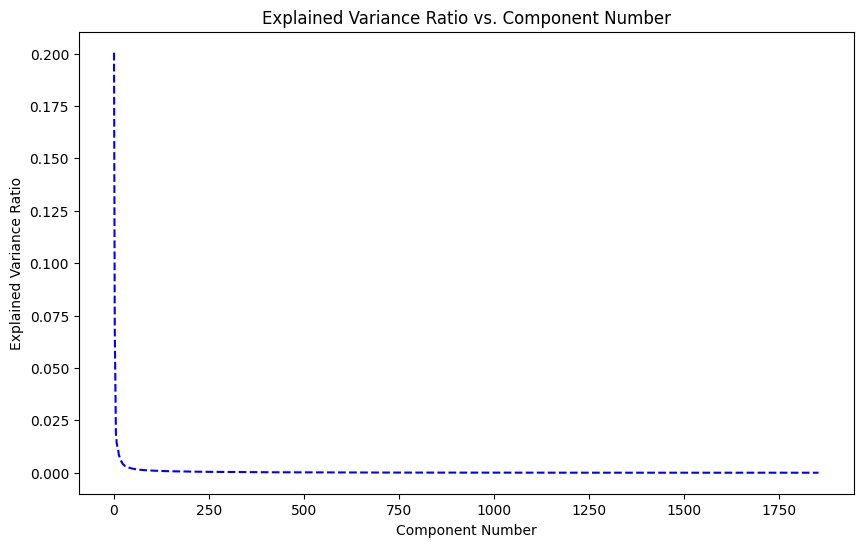

In [731]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(range(1, len(explained_variance_ratio) + 1), 
  explained_variance_ratio, ls="--", color="blue")
ax.set_xlabel("Component Number")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Explained Variance Ratio vs. Component Number")

plt.show()

In [732]:
n_components = np.where(explained_variance_ratio_csum >= 0.9)[0][0] + 1
print(f"n_components={n_components}")

n_components=270


In [749]:
k_values = list(range(1, 5))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train_translated, y_train)
  y_pred = knn.predict(X_test_translated)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

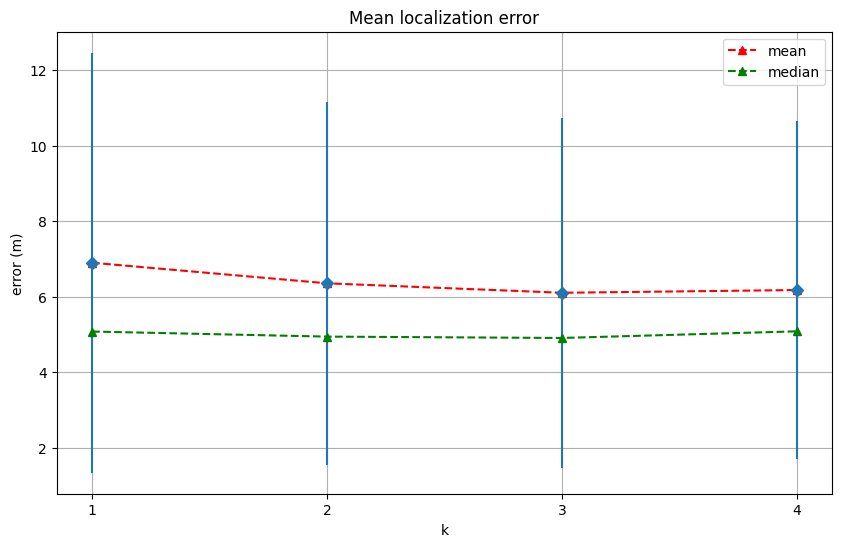

In [750]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [733]:
pca = PCA(n_components=n_components)
_ = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [734]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train_pca, y_train)
  y_pred = knn.predict(X_test_pca)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

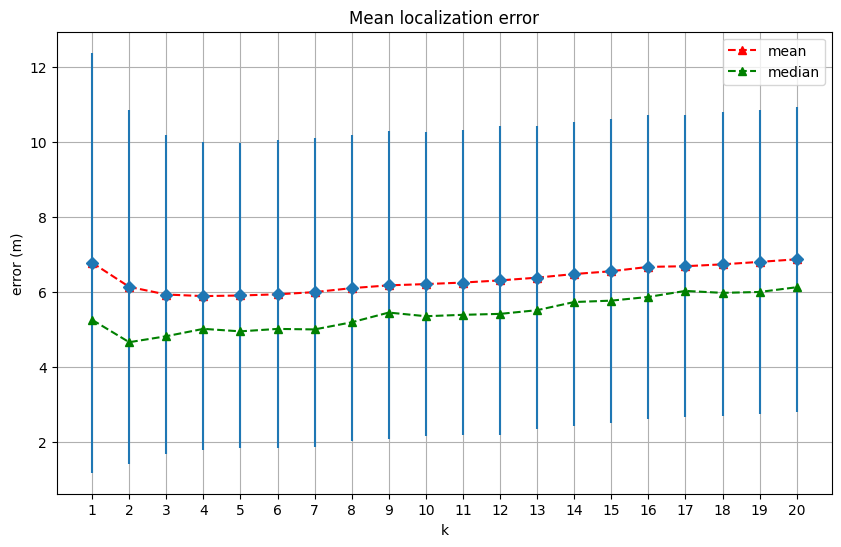

In [735]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [736]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=5.89m, std_error=4.10m


In [737]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=6.78m, std_error=5.59m


### `kNN` + `KernelPCA`

In [537]:
from sklearn.decomposition import KernelPCA

In [538]:
kernel_pca = KernelPCA(kernel="linear")
_ = kernel_pca.fit(X_train_scaled)

In [539]:
n_components = np.where(np.cumsum(kernel_pca.eigenvalues_ / kernel_pca.eigenvalues_.sum()) > 0.9)[0][0] + 1

In [540]:
n_components

233

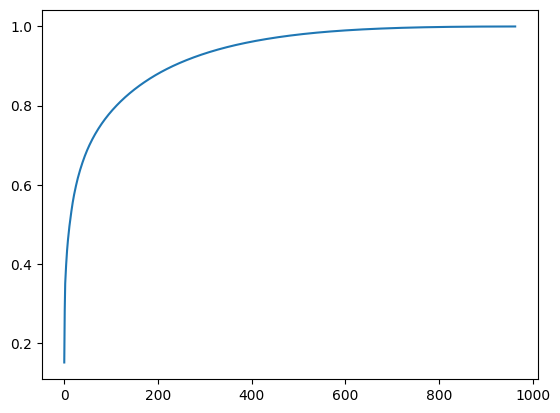

In [541]:
plt.plot(range(len(kernel_pca.eigenvalues_)), np.cumsum(kernel_pca.eigenvalues_ / kernel_pca.eigenvalues_.sum()))

In [542]:
kernel_pca = KernelPCA(n_components=n_components, kernel="linear")

_ = kernel_pca.fit(X_train_scaled)
X_train_kpca = kernel_pca.transform(X_train_scaled)
X_test_kpca = kernel_pca.transform(X_test_scaled)

In [543]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="uniform", leaf_size=17, algorithm="ball_tree")
  knn.fit(X_train_kpca, y_train)
  y_pred = knn.predict(X_test_kpca)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

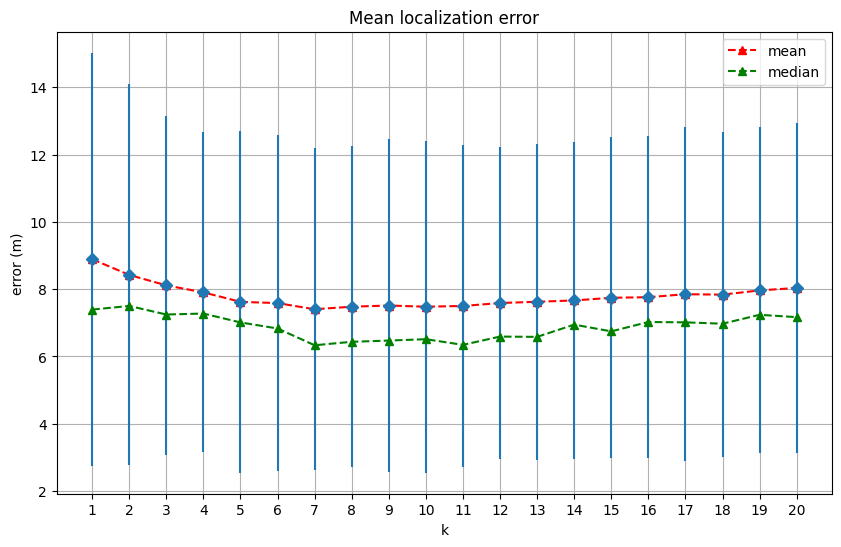

In [544]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [545]:
best_k_idx = 3
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=4, mean_error=7.90m, std_error=4.76m


In [546]:
best_k_idx = 1
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=2, mean_error=8.42m, std_error=5.66m


In [547]:
best_k_idx = 2
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=3, mean_error=8.11m, std_error=5.03m


In [548]:
best_k_idx = 0
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=1, mean_error=8.89m, std_error=6.14m
